# It is to describe relationship between raster positions (in pixel/line coordinates) and georeferenced coordinates

[GDAL](https://gdal.org/user/raster_data_model.html ) datasets have two ways of describing the relationship between raster positions (in pixel/line coordinates) and georeferenced coordinates. The first, and most commonly used is the **affine transform** (the other is GCPs).

The affine transform consists of six coefficients returned by GDALDataset::GetGeoTransform() which map pixel/line coordinates into georeferenced space using the following relationship:

Xgeo = GT(0) + Xpixel * GT(1) + Yline * GT(2)

Ygeo = GT(3) + Xpixel * GT(4) + Yline * GT(5)

In case of north up images, the GT(2) and GT(4) coefficients are zero, and the GT(1) is pixel width, and GT(5) is pixel height. The (GT(0),GT(3)) position is the **top left corner of the top left pixel** of the raster.

Note that the pixel/line coordinates in the above are **from** (0.0,0.0) at the **top left corner** of the **top left pixel** **to** (width_in_pixels,height_in_pixels) at the **bottom right corner** of **the bottom right pixel**. The pixel/line location of the center of the top left pixel would therefore be (0.5,0.5).

# One way to extract affine transform

In [1]:
from osgeo import gdal
import numpy as np

fname = "/work/qiu/LCZ42_GEE/00017_22007_Lagos/autumn/22007_autumn.tif"

dataFile = gdal.Open(fname)
GT = np.array(dataFile.GetGeoTransform())

print(GT)

[ 5.39389308e+05  1.00000000e+01  0.00000000e+00  7.17799119e+05
  0.00000000e+00 -1.00000000e+01]


**notice that the GT(1) is positive and GT(5) is negative!**

- GT(1) and GT(5) is the **Pixel Size** in the output of gdalino
- GT(0) and GT(3) is the **Origin** in the output of gdalino

# The other way to extract affine transform

In [2]:
import rasterio
from pyproj import Proj, transform
from affine import Affine

with rasterio.open(fname) as r:
        T0 = r.transform  # upper-left pixel corner affine transform
        p1 = Proj(r.crs)
        A = r.read()  # pixel values

# All rows and columns
# cols, rows = np.meshgrid(np.arange(A.shape[2]), np.arange(A.shape[1]))

# Get affine transform for pixel centres
T1 = T0 * Affine.translation(0.5, 0.5)

print(T0)
# # Function to convert pixel row/column index (from 0) to easting/northing at centre
# rc2en = lambda r, c: (c, r) * T1

# # All eastings and northings (there is probably a faster way to do this)
# eastings, northings = np.vectorize(rc2en, otypes=[np.float, np.float])(rows, cols)    

| 10.00, 0.00, 539389.31|
| 0.00,-10.00, 717799.12|
| 0.00, 0.00, 1.00|


# Be careful when setting this information to created tif files

In [3]:
from IPython.display import Image

Imagine that you are creating a classificaiton map using image geotiff files:
- the patch size is 10x10 (patchSize)
- one patch get one label



## When there is no padding:

- you first get a patch of 10x10 (from the top left area of the image), and predict a label, like this

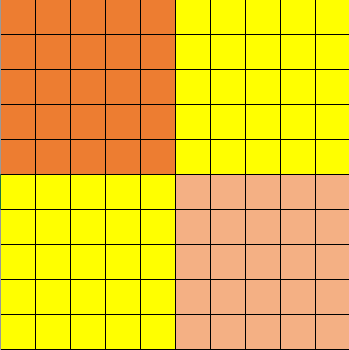

In [4]:
Image(filename=r'./files/patch2label_grid.png')

- This predicted label belongs to the location of the center corner in the real world, i.e., the corner of four colored sub-patches: 

    X = GT(0) + p_Size/2 * GT(1) + p_Size/2 * 0
    
    Y = GT(3) + p_Size/2 * 0 + p_Size/2 * GT(5)
    
- Then, you use slidding window to get the subsequent patches and predict the labels.The step of the slidding window depends on the resolution of the classification map.So the step is related to the pixel size of the classification map (pixel size of classification result is step times the pixel size of image: S * p_Size).
- When you try to save this predicted labels in geotiff, you have to be careful when setting the affine transform. **Becasue now the first predicted label's center (0.5,0.5) is located in the location of (p_Size/2, p_Size/2) of the image, i.e., (X, Y)**, **the affine transform of the classification map is**: 

    (X-S/2 * GT(1), GT(1) * S, 0, Y-S/2 * GT(5), 0, GT(5) * S) **(Keep in mind that it is always - going from down right direction to top left direction)**
    
    i.e.,
    
    (GT(0) + p_Size/2 * GT(1) - S/2 * GT(1), GT(1) * S, 0, GT(3) + p_Size/2 * GT(5) - S/2 * GT(5), 0, GT(5) * S)
    
    i.e.,
    
    (GT(0) + (p_Size-S)/2 * GT(1), GT(1) * S, 0, GT(3) + (p_Size-S)/2 * GT(5), 0, GT(5) * S)

## When there is padding to output a perfectly aligned classification map:

- So the question is **how much padding** in order to output a classification map with the same affine transform?

- Similar as before AffineGeoTransform of classiifcation map is ( ?, GT(1) * S, 0, ?,  GT(5) * S)

- If the top left corner of the first (top left) classification pixel is (GT(0), GT(3)), then the center of this pixel is located in (GT(0)+ GT(1) * S * 0.5, GT(3)+ GT(5) * S * 0.5). **(Keep in mind that it is always + going from top left to down right)**  

- then you should extract a patch from the image that is centerred in (GT(0)+GT(1) * S * 0.5, GT(3)+ GT(5) * S * 0.5). Image the step (S) is 2 and the patch size is 10 as in the previous example, then the extracted patches should be centerred in the (1,1) of the image! Therefore the padding should be 4 in upper and left direction. **More generally, the padding should be (p_Size/2-S/2) in upper and left direction**.

- If this is the case (I made no mistakes), then the affine transform of the predictions should always be different unless the padding is done by (p_Size/2-S/2) in upper and left direction.
- Notice that when p_Size == S, there is no need for padding, and the affine transform is the same between the image and the classification map! 

# The key points are:

- the origin coordinates in affine transform are the top left corner of top left pixel;
- the resolution in affine transform is positive in x direction and negative in y direction;
- the classification pixel should be perfectly aligned with the extracted image patch